In [ ]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import warnings

In [ ]:
# Suppress warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Load the dataset
Final_Data = pd.read_csv('/content/dataset.csv')

In [ ]:
# Data Exploration
print("Dataset shape:", Final_Data.shape)
print("\nFirst 5 rows:")
print(Final_Data.head())
print("\nLast 5 rows:")
print(Final_Data.tail())

# Check for missing values
print("\nMissing values per column:")
print(Final_Data.isnull().sum())

Dataset shape: (9179, 18)

First 5 rows:
  Database Fundamentals Computer Architecture Distributed Computing Systems  \
0          Professional        Not Interested                Not Interested   
1          Professional                  Poor                Not Interested   
2          Professional              Beginner                Not Interested   
3          Professional               Average                Not Interested   
4          Professional          Intermediate                Not Interested   

   Cyber Security      Networking Software Development Programming Skills  \
0  Not Interested  Not Interested       Not Interested     Not Interested   
1  Not Interested  Not Interested       Not Interested     Not Interested   
2  Not Interested  Not Interested       Not Interested     Not Interested   
3  Not Interested  Not Interested       Not Interested     Not Interested   
4  Not Interested  Not Interested       Not Interested     Not Interested   

  Project Management 

In [ ]:
# Drop the first column as it seems to be an index
Final_Data.drop(Final_Data.columns[0], axis=1, inplace=True)

# Data Preprocessing

# Define the skill levels mapping to numerical values
skill_level_mapping = {
    'Not Interested': 0,
    'Poor': 1,
    'Beginner': 2,
    'Average': 3,
    'Intermediate': 4,
    'Professional': 5,
    'Excellent': 6,
    'Highly Interested': 6,  # Assuming 'Highly Interested' is similar to 'Excellent'
    'No Comments': 0         # Treating 'No Comments' as 'Not Interested'
}


In [ ]:
# Apply the mapping to all skill columns (all columns except the last one which is 'Role')
skill_columns = Final_Data.columns[:-1]
for col in skill_columns:
    Final_Data[col] = Final_Data[col].map(skill_level_mapping)

# Handle missing values in Graphics Designing column (only 1 missing value)
Final_Data['Graphics Designing'].fillna(Final_Data['Graphics Designing'].mode()[0], inplace=True)

In [ ]:
# Encode the target variable 'Role'
label_encoder = LabelEncoder()
Final_Data['Role'] = label_encoder.fit_transform(Final_Data['Role'])

In [ ]:
# Feature Engineering

# 1. Create a feature for the number of skills the person is interested in (score > 0)
Final_Data['num_interested_skills'] = (Final_Data[skill_columns] > 0).sum(axis=1)

# 2. Create a feature for the number of professional/excellent skills
Final_Data['num_professional_skills'] = (Final_Data[skill_columns] >= 5).sum(axis=1)

# 3. Create a feature for the average skill level
Final_Data['avg_skill_level'] = Final_Data[skill_columns].mean(axis=1)

# 4. Create a feature for the maximum skill level
Final_Data['max_skill_level'] = Final_Data[skill_columns].max(axis=1)


In [ ]:
# 5. Create a feature for the skill with the highest level
Final_Data['best_skill'] = Final_Data[skill_columns].idxmax(axis=1)

# One-hot encode the best_skill feature
Final_Data = pd.get_dummies(Final_Data, columns=['best_skill'], prefix='best')

# Split the data into features and target
X = Final_Data.drop('Role', axis=1)
y = Final_Data['Role']

# Feature Selection - Select top 20 features
selector = SelectKBest(chi2, k=20)
X_selected = selector.fit_transform(X, y)

# Get the selected features
selected_features = X.columns[selector.get_support()]
X = X[selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Create a preprocessing pipeline
numeric_features = X.columns.tolist()
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', 'passthrough')  # We'll let the models handle scaling if needed
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])


In [ ]:
# Define multiple models to try
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss', use_label_encoder=False),
    'LightGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0),
    'SVM': SVC(random_state=42, probability=True),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

In [ ]:
# Hyperparameter grids for tuning
param_grids = {
    'Random Forest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5]
    },
    'Gradient Boosting': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.1, 0.05],
        'model__max_depth': [3, 5]
    },
    'XGBoost': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.1, 0.05],
        'model__max_depth': [3, 6]
    },
    'LightGBM': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.1, 0.05],
        'model__num_leaves': [31, 63]
    },
    'CatBoost': {
        'model__iterations': [100, 200],
        'model__learning_rate': [0.1, 0.05],
        'model__depth': [4, 6]
    },
    'SVM': {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf']
    },
    'KNN': {
        'model__n_neighbors': [3, 5, 7],
        'model__weights': ['uniform', 'distance']
    }
}

In [ ]:
# Train and evaluate each model with hyperparameter tuning
best_models = {}
results = []

for name, model in models.items():
    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

In [ ]:
# Train and evaluate each model with hyperparameter tuning
best_models = {}
results = []

for name, model in models.items():
    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    # Skip tuning for Naive Bayes as it has few hyperparameters
    if name == 'Naive Bayes':
        pipeline.fit(X_train, y_train)
        best_models[name] = pipeline
    else:
        # Perform grid search with cross-validation
        grid_search = GridSearchCV(
            pipeline,
            param_grids[name],
            cv=5,
            scoring='accuracy',
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        best_models[name] = grid_search.best_estimator_

    # Evaluate on test set
    y_pred = best_models[name].predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Cross-validation score
    cv_scores = cross_val_score(best_models[name], X, y, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()

    results.append({
        'Model': name,
        'Test Accuracy': accuracy,
        'CV Mean Accuracy': cv_mean,
        'Best Params': best_models[name].get_params() if name != 'Naive Bayes' else 'Default'
    })

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60
[LightGBM] [Info] Number of data points in the train set: 7343, number of used features: 20
[LightGBM] [Info] Start training from score -2.833077
[LightGBM] [Info] Start training from score -2.833077
[LightGBM] [Info] Start training from score -2.833077
[LightGBM] [Info] Start training from score -2.833077
[LightGBM] [Info] Start training from score -2.833077
[LightGBM] [Info] Start training from score -2.833077
[LightGBM] [Info] Start training from score -2.833077
[LightGBM] [Info] Start training from score -2.833077
[LightGBM] [Info] Start training from score -2.835395
[LightGBM] [Info] Start training from score -2.833077
[LightGBM] [Info] Start training from score -2.833077
[LightGBM] [Info] Start training from score -2.833077
[L

In [ ]:
# Display results
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
print(results_df.sort_values(by='Test Accuracy', ascending=False))



Model Performance Comparison:
               Model  Test Accuracy  CV Mean Accuracy  \
2            XGBoost       0.767429          0.741585   
1  Gradient Boosting       0.766340          0.740169   
4           CatBoost       0.766340          0.738533   
0      Random Forest       0.763072          0.709883   
3           LightGBM       0.763072          0.739298   
5                SVM       0.735294          0.701602   
6                KNN       0.734205          0.315173   
7        Naive Bayes       0.718410          0.675996   

                                         Best Params  
2  {'memory': None, 'steps': [('preprocessor', Co...  
1  {'memory': None, 'steps': [('preprocessor', Co...  
4  {'memory': None, 'steps': [('preprocessor', Co...  
0  {'memory': None, 'steps': [('preprocessor', Co...  
3  {'memory': None, 'steps': [('preprocessor', Co...  
5  {'memory': None, 'steps': [('preprocessor', Co...  
6  {'memory': None, 'steps': [('preprocessor', Co...  
7              

In [22]:
# Create an ensemble of the top models
top_models = [
    ('Random Forest', best_models['Random Forest']),
    ('XGBoost', best_models['XGBoost']),
    ('LightGBM', best_models['LightGBM']),
    ('CatBoost', best_models['CatBoost'])
]

ensemble = VotingClassifier(
    estimators=top_models,
    voting='soft'  # Use soft voting for probability-based weighting
)

ensemble.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60
[LightGBM] [Info] Number of data points in the train set: 7343, number of used features: 20
[LightGBM] [Info] Start training from score -2.833077
[LightGBM] [Info] Start training from score -2.833077
[LightGBM] [Info] Start training from score -2.833077
[LightGBM] [Info] Start training from score -2.833077
[LightGBM] [Info] Start training from score -2.833077
[LightGBM] [Info] Start training from score -2.833077
[LightGBM] [Info] Start training from score -2.833077
[LightGBM] [Info] Start training from score -2.833077
[LightGBM] [Info] Start training from score -2.835395
[LightGBM] [Info] Start training from score -2.833077
[LightGBM] [Info] Start training from score -2.833077
[LightGBM] [Info] Start training from score -2.833077
[L

VotingClassifier(estimators=[('Random Forest',
                              Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('num',
                                                                                Pipeline(steps=[('imputer',
                                                                                                 SimpleImputer(strategy='median')),
                                                                                                ('scaler',
                                                                                                 'passthrough')]),
                                                                                ['Software '
                                                                                 'Development',
                                                                                 'Project '
                                                                                 'Management',
                                                                                 'Technical '
                                                                                 'Communication',
                                                                                 'Software '
                                                                                 'Engineering',
                                                                                 'best_AI '
                                                                                 'ML',
                                                                                 'best_Business '
                                                                                 'Analysis',
                                                                                 'best_Co...
                                                                                 'Science',
                                                                                 'best_Distributed '
                                                                                 'Computing '
                                                                                 'Systems',
                                                                                 'best_Graphics '
                                                                                 'Designing',
                                                                                 'best_Networking',
                                                                                 'best_Programming '
                                                                                 'Skills',
                                                                                 'best_Project '
                                                                                 'Management',
                                                                                 'best_Software '
                                                                                 'Development',
                                                                                 'best_Software '
                                                                                 'Engineering',
                                                                                 'best_Technical '
                                                                                 'Communication',
                                                                                 'best_Troubleshooting '
                                                                                 'skills'])])),
                                              ('model',
                                               <catboost.core.CatBoostClassifier object at 0x79394d304a10>)]))],
                 voting='soft')

In [23]:
# Evaluate the ensemble
y_pred_ensemble = ensemble.predict(X_test)
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
ensemble_cv = cross_val_score(ensemble, X, y, cv=5, scoring='accuracy').mean()

print("\nEnsemble Model Performance:")
print(f"Test Accuracy: {ensemble_accuracy:.4f}")
print(f"Cross-Validation Mean Accuracy: {ensemble_cv:.4f}")

# Detailed evaluation of the ensemble model
print("\nEnsemble Classification Report:")
print(classification_report(y_test, y_pred_ensemble, target_names=label_encoder.classes_))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60
[LightGBM] [Info] Number of data points in the train set: 7343, number of used features: 20
[LightGBM] [Info] Start training from score -2.833077
[LightGBM] [Info] Start training from score -2.833077
[LightGBM] [Info] Start training from score -2.833077
[LightGBM] [Info] Start training from score -2.833077
[LightGBM] [Info] Start training from score -2.833077
[LightGBM] [Info] Start training from score -2.833077
[LightGBM] [Info] Start training from score -2.833077
[LightGBM] [Info] Start training from score -2.833077
[LightGBM] [Info] Start training from score -2.835395
[LightGBM] [Info] Start training from score -2.833077
[LightGBM] [Info] Start training from score -2.833077
[LightGBM] [Info] Start training from score -2.833077
[L

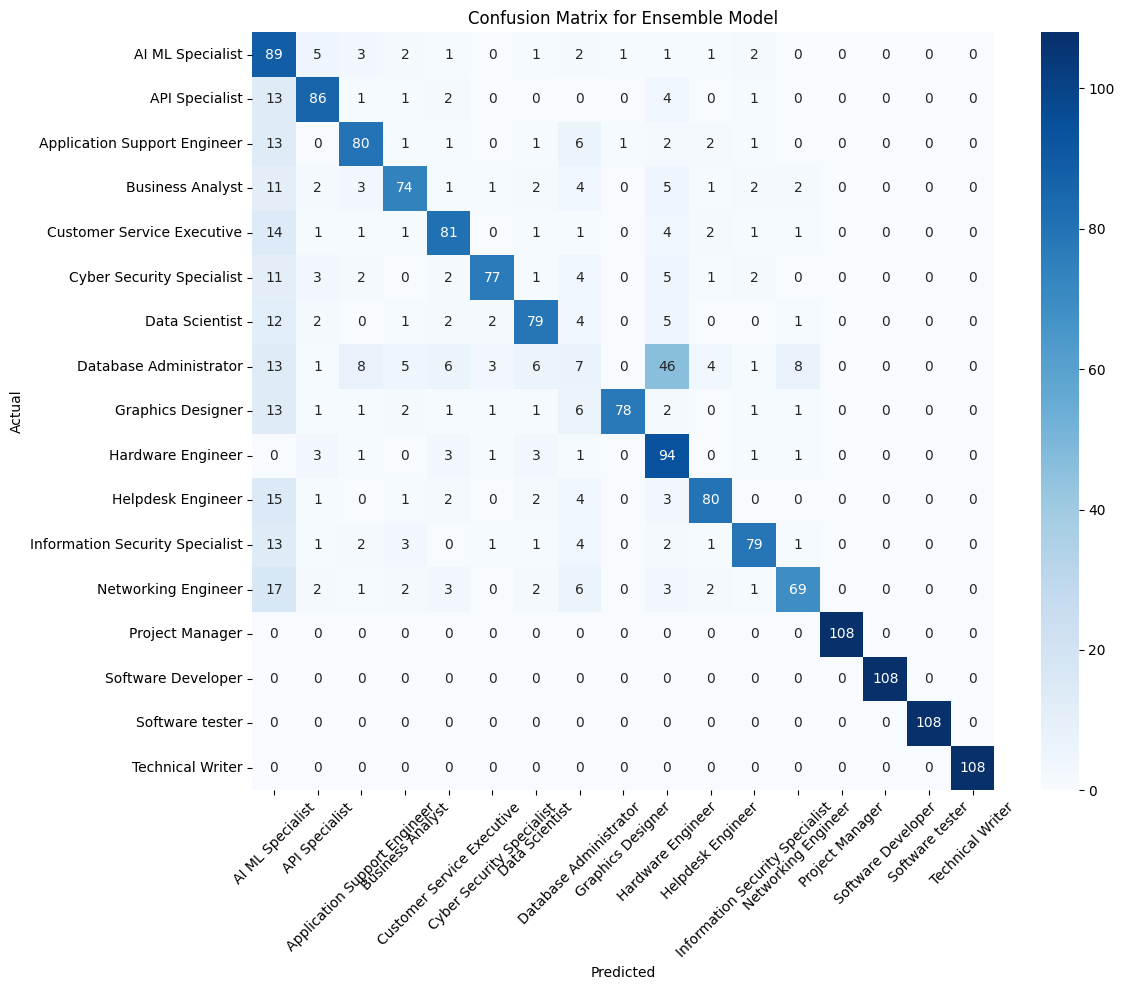

In [24]:
# Confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred_ensemble)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Ensemble Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

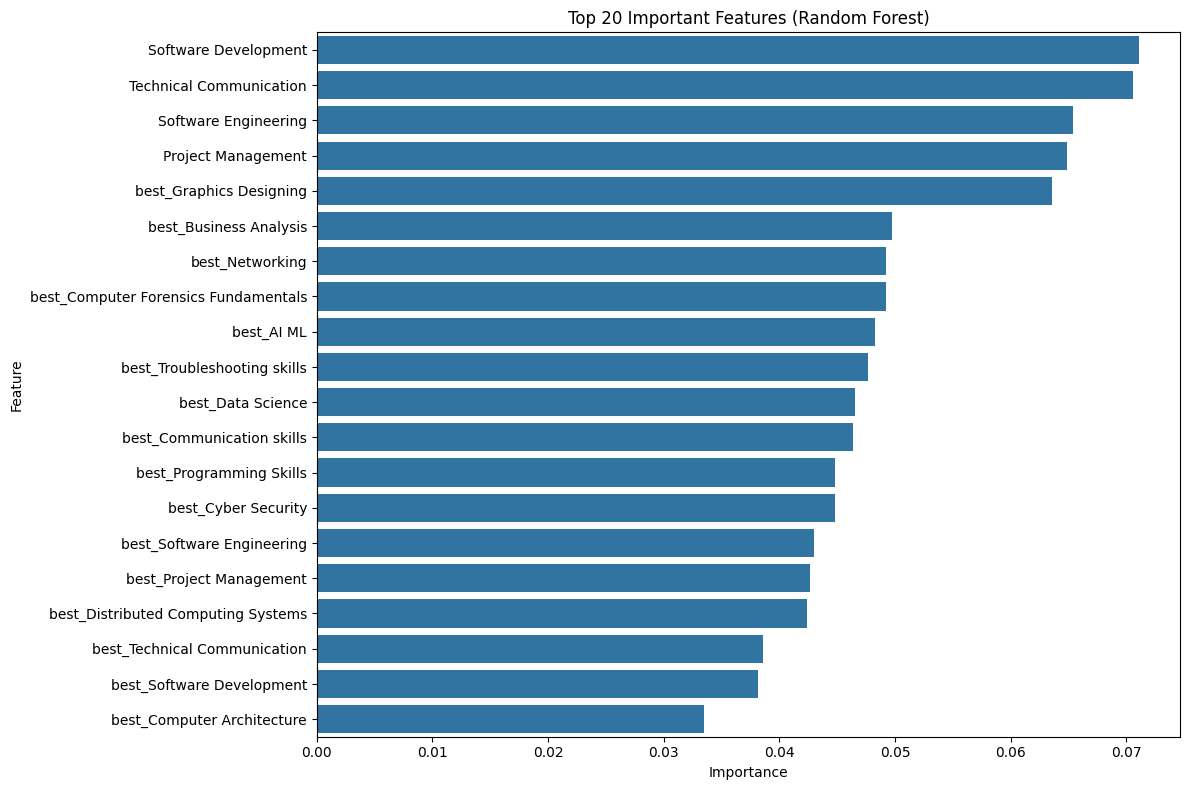

In [25]:
# Feature importance from Random Forest
if 'Random Forest' in best_models:
    rf_model = best_models['Random Forest'].named_steps['model']
    if hasattr(rf_model, 'feature_importances_'):
        feature_importances = pd.DataFrame({
            'Feature': selected_features,
            'Importance': rf_model.feature_importances_
        }).sort_values(by='Importance', ascending=False)

        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20))
        plt.title('Top 20 Important Features (Random Forest)')
        plt.tight_layout()
        plt.show()

In [26]:
# Save the best model (ensemble)
import joblib
joblib.dump(ensemble, 'career_role_ensemble_model.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(selector, 'feature_selector.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')

print("\nBest model (ensemble) and supporting files saved to disk.")


Best model (ensemble) and supporting files saved to disk.
